In [4]:
%pylab inline

import os
import spacy
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from unicodedata import normalize

# This is a anti-pattern to disable warnings
# I'm using just for a simplification
import warnings
warnings.filterwarnings("ignore")

# Local directory to fetch the data
ROOT_DIR = os.getcwd()

# Brazilian Portuguese using Spacy S2
nlp = spacy.load('pt_core_news_sm')

# Personalized Stopword lists
# combining Spacy and NLTK 
stoplist = pd.read_csv(ROOT_DIR + '/stopwords_pt_br.txt',
                       sep='@@@@@@@@')

stoplist = list(stoplist.word.values)
punctuations = string.punctuation

# Increase the view to get a better table visualization
pd.set_option('display.max_rows', 500)

# I'll use this separator to fetch the 
# DF in a single column
df_cf_88 = pd.read_csv(ROOT_DIR + '/constituicao.txt',
                       header=None,
                       sep='@@@@@@@@')
df_cf_88.columns = ['text']
df_cf_88.head(5)

Populating the interactive namespace from numpy and matplotlib


,text
0,"Art. 1º A República Federativa do Brasil, form..."
1,"Art. 2º São Poderes da União, independentes e ..."
2,Art. 3º Constituem objetivos fundamentais da R...
3,Art. 4º A República Federativa do Brasil rege-...
4,"Art. 5º Todos são iguais perante a lei, sem di..."


In [5]:
# A single article
df_cf_88['text'].iloc[142]

'Art. 143. O serviço militar é obrigatório nos termos da lei. § 1º Às Forças Armadas compete, na forma da lei, atribuir serviço alternativo aos que, em tempo de paz, após alistados, alegarem imperativo de consciência, entendendo-se como tal o decorrente de crença religiosa e de convicção filosófica ou política, para se eximirem de atividades de caráter essencialmente militar.           (Regulamento) § 2º - As mulheres e os eclesiásticos ficam isentos do serviço militar obrigatório em tempo de paz, sujeitos, porém, a outros encargos que a lei lhes atribuir.   (Regulamento)'

In [6]:
# Pre-Processing
special_by_space = re.compile('[/(){}\[\]"\|@,;]')

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = text.replace("art", " ")
    text = text.replace("1o", " ")
    text = text.replace("2o", " ")
    text = text.replace("3o", " ")
    text = text.replace("4o", " ")
    text = text.replace("5o", " ")
    text = text.replace("6o", " ")
    text = text.replace("7o", " ")
    text = text.replace("8o", " ")
    text = text.replace("9o", " ")    
    text = text.replace("10o", " ")
    text = text.replace("  ", " ")    
    text = special_by_space.sub(" ", text)
    text = " ".join(word for word in text.split() if word not in stoplist)
    return text


def remove_punctuation(text):
    """
     This function remove the replacement_patterns from input string.
     Parameters
     ----------
     text : String
         Input string to the function.
     Returns
     -------
     text : String
         Output string after replacement.
     """
    rem = string.punctuation
    pattern = r"[{}]".format(rem)
    text = re.sub(r"[-()\"#/@;:&<>{}`+=~|.!?,[\]©_*]", " ", text)
    text = text.replace(pattern, "")
    return text


def replace_ptbr_char_by_word(word):
    word = str(word)
    word = normalize("NFKD", word).encode("ASCII", "ignore").decode("ASCII")
    return word


def remove_pt_br_char_by_text(text):
    text = str(text)
    text = " ".join(
        replace_ptbr_char_by_word(word) for word in text.split() if word not in stoplist
    )
    return text


df_cf_88["text"] \
    = df_cf_88["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
df_cf_88["text"] = df_cf_88["text"].apply(remove_pt_br_char_by_text)
df_cf_88["text"] = df_cf_88["text"].apply(clean_text)
df_cf_88["text"] = df_cf_88["text"].str.replace("[^\w\s]", "")
df_cf_88["text"] = df_cf_88["text"].apply(remove_punctuation)
df_cf_88['text'] = df_cf_88['text'].str.strip()

In [7]:
# Check the same article
df_cf_88['text'].iloc[142].strip()

'143 servico militar obrigatorio termos lei forcas armadas compete lei atribuir servico alternativo paz alistados alegarem imperativo consciencia entendendose decorrente crenca religiosa conviccao filosofica politica eximirem atividades carater essencialmente militar regulamento  mulheres eclesiasticos ficam isentos servico militar obrigatorio paz sujeitos porem encargos lei atribuir regulamento'

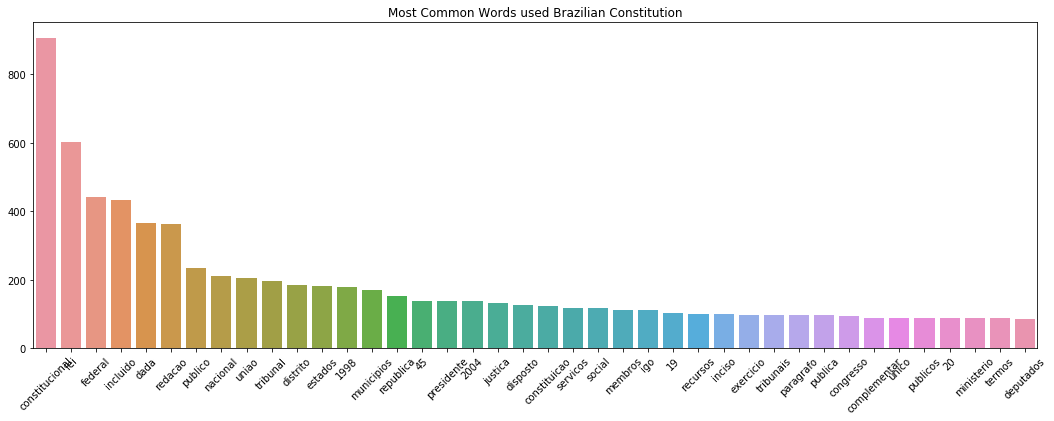

In [8]:
def get_word_frequency(df):
    # Word Frequency per Category
    def cleanup_text(docs, logging=False):
        texts = []
        counter = 1
        for doc in docs:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(docs)))
            counter += 1
            doc = nlp(doc, disable=['parser', 'ner'])
            tokens = [str(tok).lower().strip() for tok in doc if tok.lemma_ != '-PRON-']            
            tokens = [tok for tok in tokens if tok not in stoplist and tok not in punctuations]
            tokens = ' '.join(tokens)
            texts.append(tokens)
        return pd.Series(texts)

    df_text = [str(text) for text in df['text']]
    df_text_clean = cleanup_text(df_text)
    df_text_clean = ' '.join(df_text_clean).split()
    df_text_clean_counts = Counter(df_text_clean)
    df_common_words = [word[0] for word in df_text_clean_counts.most_common(41)]
    df_common_counts = [word[1] for word in df_text_clean_counts.most_common(41)]
    df_common_words.pop(0)
    df_common_counts.pop(0)

    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=df_common_words, y=df_common_counts)
    plt.title(f'Most Common Words used Brazilian Constitution')
    plt.xticks(rotation=45)
    plt.show()
    
    
get_word_frequency(df_cf_88)

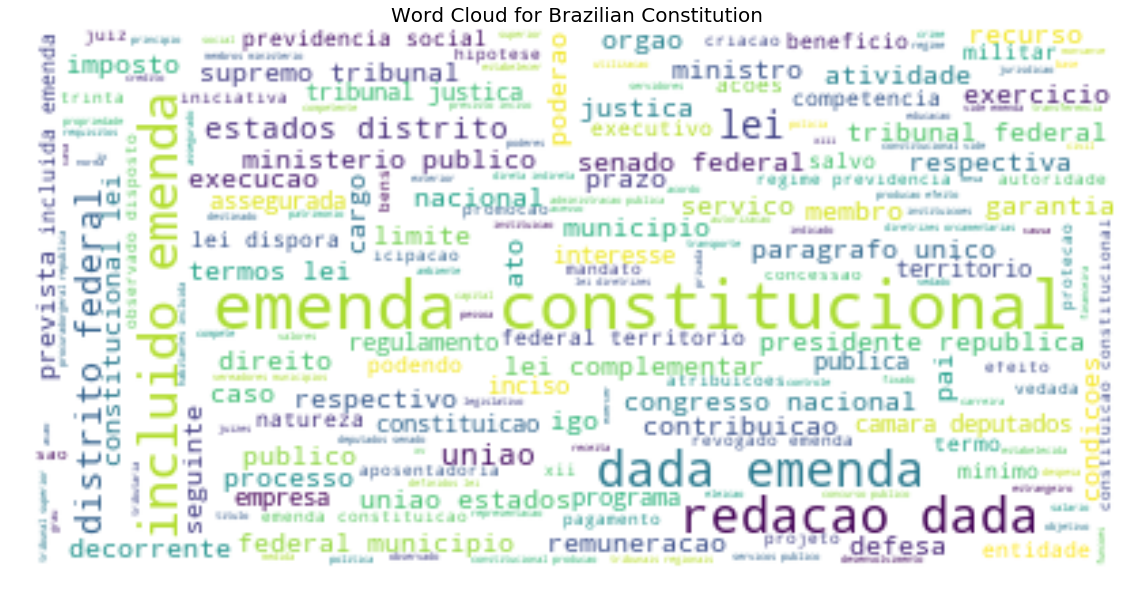

In [9]:
# Word cloud with most common words
def show_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=stoplist, background_color="white").generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(25,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Brazilian Constitution', fontsize=20)
    plt.axis("off")
    plt.show()

    
def get_wordcloud(df):
    # Get all texts and generate a cloud
    text = " ".join(str(review) for review in df.text)
    show_wordcloud(text) 
    
get_wordcloud(df_cf_88)

In [10]:
def get_tfidf_df(df):
    # This one came from Analytics Vidhya
    # Ref: https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

    # Generate the TF 
    tf1 \
        = (df['text'][:])\
        .apply(lambda x: pd.value_counts(x.split(" ")))\
        .sum(axis = 0).reset_index()

    tf1.columns = ['word','tf']

    # Remove some instances with NaN
    tf1 = tf1.dropna()
    df = df.dropna()

    # Calculate the log of the terms according to the TF
    for i, word in enumerate(tf1['word']):
        tf1.loc[i, 'idf'] \
            = np.log(df.shape[0]\
                     /(len(df[df['text'].str.contains(word)])))

    # Full calculation of TF-IDF
    tf1['tfidf'] = tf1['tf'] * tf1['idf']
    

    
    return tf1.head(300).sort_values(by=['tfidf'], ascending=False).reset_index(drop=True)
    
    
df_cf_88_tfidf = get_tfidf_df(df_cf_88)
df_cf_88_tfidf.head(30)

,word,tf,idf,tfidf
0,constitucional,906.0,0.661649,599.453553
1,emenda,910.0,0.646264,588.099871
2,incluido,434.0,1.139434,494.514479
3,federal,442.0,0.742337,328.113142
4,tribunal,197.0,1.629641,321.039202
5,2004,137.0,2.225624,304.910495
6,45,138.0,2.055725,283.690052
7,municipios,169.0,1.478410,249.851231
8,estados,182.0,1.217396,221.566040
9,distrito,185.0,1.190728,220.284602


In [11]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'familia']

,word,tf,idf,tfidf
125,familia,17.0,2.813411,47.827982


In [12]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'liberdade']

,word,tf,idf,tfidf
105,liberdade,16.0,3.575551,57.208812


In [13]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'povo']

,word,tf,idf,tfidf


In [14]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'militares']

,word,tf,idf,tfidf
19,militares,58.0,2.882404,167.179408


In [15]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'direitos']

,word,tf,idf,tfidf
24,direitos,79.0,1.783791,140.919513


In [37]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'dever']

,word,tf,idf,tfidf


In [17]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'habeas']

,word,tf,idf,tfidf
48,habeas,28.0,3.442019,96.376543


In [18]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'brasileiros']

,word,tf,idf,tfidf
54,brasileiros,35.0,2.631089,92.088121


In [19]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'judiciario']

,word,tf,idf,tfidf
58,judiciario,37.0,2.430418,89.925483


In [20]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'executivo']

,word,tf,idf,tfidf
74,executivo,32.0,2.430418,77.773391


In [21]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'legislativo']

,word,tf,idf,tfidf
85,legislativo,28.0,2.525729,70.720402


In [22]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'congresso']

,word,tf,idf,tfidf
18,congresso,94.0,1.783791,167.676382


In [23]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'propriedade']

,word,tf,idf,tfidf
68,propriedade,28.0,2.882404,80.7073


In [24]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'patrimonio']

,word,tf,idf,tfidf
69,patrimonio,29.0,2.748872,79.717294


In [25]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'seguranca']

,word,tf,idf,tfidf
77,seguranca,27.0,2.748872,74.219549


In [26]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'livre']

,word,tf,idf,tfidf
78,livre,26.0,2.813411,73.148679


In [27]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'drogas']

,word,tf,idf,tfidf
171,drogas,7.0,4.135167,28.946166


In [28]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'filhos']

,word,tf,idf,tfidf
170,filhos,7.0,4.135167,28.946166


In [29]:
df_cf_88_tfidf[df_cf_88_tfidf['word'] == 'racismo']

,word,tf,idf,tfidf
256,racismo,2.0,4.828314,9.656627


In [30]:
def get_word_ngrams_list(df, word_ngram):

    def get_top_word_n_bigram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(word_ngram, word_ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]


    common_words = get_top_word_n_bigram(df['text'], 20)
    df3 = pd.DataFrame(common_words, columns = ['ngram' , 'qty'])

    return df3

get_word_ngrams_list(df_cf_88, 2)

,ngram,qty
0,emenda constitucional,868
1,incluido emenda,427
2,dada emenda,365
3,redacao dada,360
4,distrito federal,185
5,constitucional 45,136
6,45 2004,136
7,estados distrito,126
8,constitucional 19,98
9,19 1998,98


In [31]:
get_word_ngrams_list(df_cf_88, 3)

,ngram,qty
0,incluido emenda constitucional,425
1,redacao dada emenda,360
2,dada emenda constitucional,357
3,emenda constitucional 45,136
4,constitucional 45 2004,136
5,estados distrito federal,126
6,emenda constitucional 19,98
7,constitucional 19 1998,98
8,emenda constitucional 20,80
9,distrito federal municipios,78


In [35]:
def get_topics(df, n_components, number_words):
    
    # Convert to list
    data = df.text.values.tolist()

    # Remove special characters
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    vectorizer = CountVectorizer(analyzer='word',       
                                 stop_words=stoplist,
                                 lowercase=True,
                                )

    data_vectorized = vectorizer.fit_transform(data)

    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

    # Build LDA Model
    lda_model = LatentDirichletAllocation(n_components=n_components,
                                          max_iter=10,
                                          learning_method='online',
                                          random_state=42,
                                          batch_size=10,
                                          evaluate_every = -1,
                                          n_jobs=-1,
                                         )
    lda_output = lda_model.fit_transform(data_vectorized)

    # Helper function
    def print_topics(model, count_vectorizer, n_top_words):
        words = count_vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(model.components_):
            print("\nTopic #%d:" % topic_idx)
            print(" ".join([words[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))

    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    lda_model.fit(data_vectorized)

    print_topics(lda_model, vectorizer, number_words)
    
    return lda_model, data_vectorized, data, lda_output, vectorizer


def get_lda_plot(lda_model, data_vectorized, vectorizer):
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel

In [36]:
lda_model, data_vectorized, data, lda_output, vectorizer = \
    get_topics(df_cf_88, n_components=10, number_words=10)


get_lda_plot(lda_model, data_vectorized, vectorizer)

Sparsicity:  1.5481638146510288 %
Topics found via LDA:

Topic #0:
adolescente crianca 65 casamento empregados prevencao jovem familiar 05 empregadores

Topic #1:
agraria programa tecnologica apoiara desportivas agricola estimulara equilibrado recebera instrumentos

Topic #2:
culturais difusao existentes culturas comunitaria tomadas comunidades grupos localidade vida

Topic #3:
emenda constitucional incluido lei dada redacao 1998 municipios social igo

Topic #4:
federal uniao estados distrito lei nacional republica presidente territorios unico

Topic #5:
emenda constitucional tribunal publico lei 45 2004 federal justica incluido

Topic #6:
obrigatorio 59 universalizacao antecipacao prioritariamente fomento oferta 212 especializado atribuir

Topic #7:
imposto precatorios exterior propriedade aliquotas renda mercadorias prestacoes contribuinte produto

Topic #8:
embarcacoes animais praticas veiculo substancias aquatico ecossistemas genetico medicamentos bebidas

Topic #9:
nacional congre

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -110.083267  -79.035530       1        1  39.984237
5       27.861082  293.328644       2        1  26.559047
4       72.441322    3.558823       3        1  15.972776
9      236.521484 -120.254677       4        1  10.204523
7       28.723061 -246.930374       5        1   3.385085
6     -238.410858 -236.052597       6        1   0.980240
2      217.958939  152.426697       7        1   0.869714
0      -90.021072  120.159195       8        1   0.848737
1     -243.225281  255.406342       9        1   0.699745
8     -311.177155   16.807230      10        1   0.495897, topic_info=     Category        Freq                   Term       Total  loglift  logprob
1267  Default  869.000000         constitucional  869.000000  30.0000  30.0000
1927  Default  874.000000                 emenda  874.000000  29.0000  29.0000
2322  Default  405.000000                federal  405.000000  28.0000  28.0000
4996  Default  190.000000                  uniao  190.000000  27.0000  27.0000
3398  Default  196.000000               nacional  196.000000  26.0000  26.0000
4969  Default  186.000000               tribunal  186.000000  25.0000  25.0000
2098  Default  168.000000                estados  168.000000  24.0000  24.0000
263   Default  133.000000                     45  133.000000  23.0000  23.0000
155   Default  132.000000                   2004  132.000000  22.0000  22.0000
4455  Default  130.000000              republica  130.000000  21.0000  21.0000
2765  Default  425.000000               incluido  425.000000  20.0000  20.0000
1791  Default  170.000000               distrito  170.000000  19.0000  19.0000
1223  Default   84.000000              congresso   84.000000  18.0000  18.0000
2708  Default   41.000000                imposto   41.000000  17.0000  17.0000
3080  Default  127.000000                justica  127.000000  16.0000  16.0000
3949  Default  121.000000             presidente  121.000000  15.0000  15.0000
4968  Default   94.000000              tribunais   94.000000  14.0000  14.0000
4175  Default  229.000000                publico  229.000000  13.0000  13.0000
1458  Default  346.000000                   dada  346.000000  12.0000  12.0000
4284  Default  344.000000                redacao  344.000000  11.0000  11.0000
128   Default   52.000000               19122003   52.000000  10.0000  10.0000
3395  Default  152.000000             municipios  152.000000   9.0000   9.0000
4889  Default   49.000000            territorios   49.000000   8.0000   8.0000
3295  Default  105.000000                membros  105.000000   7.0000   7.0000
3050  Default   69.000000                 juizes   69.000000   6.0000   6.0000
152   Default   68.000000                   2001   68.000000   5.0000   5.0000
1588  Default   72.000000              deputados   72.000000   4.0000   4.0000
4722  Default  119.000000                 social  119.000000   3.0000   3.0000
3886  Default   52.000000                  prazo   52.000000   2.0000   2.0000
1696  Default   49.000000                   dias   49.000000   1.0000   1.0000
149    Topic1   87.385205                     20   87.919618   0.9106  -5.0922
3986   Topic1   63.969321            previdencia   64.499363   0.9084  -5.4041
1978   Topic1   71.330060                 ensino   71.996254   0.9074  -5.2952
4599   Topic1   52.857878                  saude   53.386963   0.9067  -5.5949
160    Topic1   52.504122                   2009   53.037756   0.9066  -5.6016
2563   Topic1   54.431412             habitantes   54.994011   0.9064  -5.5655
151    Topic1   46.790319                   2000   47.319588   0.9054  -5.7168
167    Topic1   45.038475                   2015   45.567641   0.9050  -5.7550
4246   Topic1   43.123819                receita   43.657646   0.9044  -5.7984
1865   Topic1   41.208580               educacao   41.737546   0.9039  -5.8438
4353   Topic1   37.698